<a href="https://colab.research.google.com/github/Searching96/global-early-signal-prediction/blob/main/global_early_signal_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🚀 Step 1: Setup Environment

In [3]:
# Install required packages
!pip install xgboost scikit-learn pandas numpy matplotlib seaborn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from xgboost.callback import EarlyStopping
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Config
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 📁 Step 2: Load Data

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset from Google Drive
# Please make sure 'dataset_early_signal.csv' is in a folder named 'global_early_signal_prediction' in your Google Drive's root.
# The path will be /content/drive/My Drive/global_early_signal_prediction/dataset_early_signal.csv
df = pd.read_csv('/content/drive/My Drive/global_early_signal_prediction/dataset_early_signal.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nBasic stats:\n{df.describe()}")

# Display sample
df.head()

Mounted at /content/drive
Dataset shape: (297, 27)

Columns: ['video_id', 'author_username', 'create_time', 'playCount_h1', 'actual_hours_h1', 'diggCount_h1', 'commentCount_h1', 'shareCount_h1', 'collectCount_h1', 'playCount_h2', 'actual_hours_h2', 'diggCount_h2', 'commentCount_h2', 'shareCount_h2', 'collectCount_h2', 'playCount_h3', 'actual_hours_h3', 'diggCount_h3', 'commentCount_h3', 'shareCount_h3', 'collectCount_h3', 'playCount_h24', 'diggCount_h24', 'commentCount_h24', 'shareCount_h24', 'collectCount_h24', 'actual_hours_h24']

Missing values:
video_id             0
author_username      0
create_time          0
playCount_h1        18
actual_hours_h1     18
diggCount_h1        18
commentCount_h1     18
shareCount_h1       18
collectCount_h1     18
playCount_h2         4
actual_hours_h2      4
diggCount_h2         4
commentCount_h2      4
shareCount_h2        4
collectCount_h2      4
playCount_h3        10
actual_hours_h3     10
diggCount_h3        10
commentCount_h3     10
shareCou

,video_id,author_username,create_time,playCount_h1,actual_hours_h1,diggCount_h1,commentCount_h1,shareCount_h1,collectCount_h1,playCount_h2,...,diggCount_h3,commentCount_h3,shareCount_h3,collectCount_h3,playCount_h24,diggCount_h24,commentCount_h24,shareCount_h24,collectCount_h24,actual_hours_h24
0,7590594297968348424,congb_,2026-01-02T10:02:45,31700.0,1.44,9275.0,247.0,227.0,481.0,41800.0,...,14200.0,314.0,384.0,759.0,128700,22400,368,638,1192,23.97
1,7590595449963285781,macvankhoa.official,2026-01-02T10:07:15,2276.0,1.36,172.0,9.0,1.0,4.0,2657.0,...,203.0,9.0,1.0,5.0,5095,266,9,4,6,23.90
2,7590619727563623687,bs.ngomonghung,2026-01-02T11:41:24,5130.0,0.79,207.0,7.0,1.0,22.0,7375.0,...,383.0,9.0,3.0,35.0,35800,1261,16,13,120,24.33
3,7590620476368522503,haiichieu,2026-01-02T11:44:19,4780.0,0.74,349.0,12.0,4.0,8.0,6630.0,...,524.0,15.0,6.0,12.0,14400,806,22,19,21,24.28
4,7590623515103988999,hansara.official,2026-01-02T11:56:07,13700.0,0.55,3399.0,135.0,149.0,250.0,30900.0,...,8394.0,188.0,282.0,576.0,145900,18200,252,590,1120,24.08


In [5]:
# 1. Kiểm tra số lượng ban đầu
print(f"📊 Số lượng mẫu ban đầu: {df.shape[0]}")

# 2. Thực hiện Drop (Chỉ quan tâm h3 và h24)
# Lý do: Đây là 2 chỉ số bắt buộc để tính Target (Growth Rate)
cols_to_check = ['playCount_h3', 'playCount_h24']
df_clean = df.dropna(subset=cols_to_check)

# 3. Quan trọng: Xử lý các ô NaN còn lại (ở h1, h2...)
# Nếu h3 có dữ liệu mà h1 bị NaN -> Coi như h1 = 0 (Lỗi thu thập hoặc chưa có view)
# Bước này giúp model không bị lỗi khi train
df_clean = df_clean.fillna(0)

# 4. Kiểm tra kết quả
n_dropped = df.shape[0] - df_clean.shape[0]
print(f"✅ Đã làm sạch xong!")
print(f"   - Số mẫu bị loại bỏ: {n_dropped}")
print(f"   - Số mẫu còn lại:    {df_clean.shape[0]}")

# Gán lại vào biến làm việc chính
df_working = df_clean.copy()

📊 Số lượng mẫu ban đầu: 297
✅ Đã làm sạch xong!
   - Số mẫu bị loại bỏ: 10
   - Số mẫu còn lại:    287


## 🔧 Step 3: Feature Engineering


In [6]:
def create_features(df):
    """
    Phiên bản tối ưu cho Growth Strategy:
    - Giữ lại Velocity, Acceleration, Engagement (Rất tốt).
    - Thêm Log Transform (Bắt buộc cho Model).
    - Loại bỏ Author Stats (Tránh Data Leakage).
    """
    df_feat = df.copy()

    # 1. TIME FEATURES (Giữ nguyên)
    df_feat['create_time'] = pd.to_datetime(df_feat['create_time'])
    df_feat['hour_of_day'] = df_feat['create_time'].dt.hour
    df_feat['day_of_week'] = df_feat['create_time'].dt.dayofweek
    df_feat['is_weekend'] = (df_feat['day_of_week'] >= 5).astype(int)

    metrics = ['playCount', 'diggCount', 'commentCount', 'shareCount', 'collectCount']

    # 2. LOG TRANSFORMS (THÊM MỚI - QUAN TRỌNG)
    # Model GBM thích làm việc với Log Scale hơn là số thô
    for metric in metrics:
        if f'{metric}_h1' in df_feat.columns:
            df_feat[f'{metric}_h1_log'] = np.log1p(df_feat[f'{metric}_h1'])
            df_feat[f'{metric}_h2_log'] = np.log1p(df_feat[f'{metric}_h2'])
            df_feat[f'{metric}_h3_log'] = np.log1p(df_feat[f'{metric}_h3'])

    # 3. GROWTH RATES & ACCELERATION (Giữ nguyên logic của bạn)
    for metric in metrics:
        if f'{metric}_h1' in df_feat.columns:
            # Growth rate (Dùng số thực để tính %)
            df_feat[f'{metric}_growth_h1_h2'] = (df_feat[f'{metric}_h2'] - df_feat[f'{metric}_h1']) / (df_feat[f'{metric}_h1'] + 1)
            df_feat[f'{metric}_growth_h2_h3'] = (df_feat[f'{metric}_h3'] - df_feat[f'{metric}_h2']) / (df_feat[f'{metric}_h2'] + 1)

            # Acceleration: Tăng tốc hay giảm tốc?
            df_feat[f'{metric}_acceleration'] = df_feat[f'{metric}_growth_h2_h3'] - df_feat[f'{metric}_growth_h1_h2']

    # 4. ENGAGEMENT RATES (Giữ nguyên - Rất quan trọng để đoán Viral)
    for hour in ['h1', 'h2', 'h3']:
        if f'playCount_{hour}' in df_feat.columns:
            view = df_feat[f'playCount_{hour}'] + 1
            df_feat[f'digg_rate_{hour}'] = df_feat[f'diggCount_{hour}'] / view
            df_feat[f'comment_rate_{hour}'] = df_feat[f'commentCount_{hour}'] / view
            df_feat[f'share_rate_{hour}'] = df_feat[f'shareCount_{hour}'] / view

            # Composite Engagement Score
            df_feat[f'engagement_score_{hour}'] = (
                df_feat[f'diggCount_{hour}'] * 1 +
                df_feat[f'commentCount_{hour}'] * 2 +  # Comment quan trọng gấp đôi
                df_feat[f'shareCount_{hour}'] * 3      # Share quan trọng gấp ba
            ) / view

    # 5. VELOCITY (Giữ nguyên - Ý tưởng hay)
    # Tốc độ tăng trưởng view/like trên mỗi giờ thực tế
    if 'actual_hours_h2' in df_feat.columns:
        for metric in ['playCount', 'diggCount']:
             df_feat[f'{metric}_velocity_h2'] = (df_feat[f'{metric}_h2'] - df_feat[f'{metric}_h1']) / (df_feat['actual_hours_h2'] + 0.1)
             # Velocity h3 (so với h2)
             time_diff = df_feat['actual_hours_h3'] - df_feat['actual_hours_h2']
             df_feat[f'{metric}_velocity_h3'] = (df_feat[f'{metric}_h3'] - df_feat[f'{metric}_h2']) / (time_diff + 0.1)

    # 6. CLEANUP
    # Chỉ giữ lại các cột số (numeric) để đưa vào Model
    df_numeric = df_feat.select_dtypes(include=[np.number])

    # Loại bỏ các cột Target (h24) nếu lỡ dính vào Feature (để tránh data leakage)
    cols_to_drop = [c for c in df_numeric.columns if '_h24' in c]
    df_numeric = df_numeric.drop(columns=cols_to_drop, errors='ignore')

    # Thay thế vô cực/NaN bằng 0
    df_numeric = df_numeric.replace([np.inf, -np.inf], 0).fillna(0)

    return df_numeric

# Create features
df_processed = create_features(df_working)

print(f"\nAfter feature engineering: {df_processed.shape}")
print(f"New features created: {df_processed.shape[1] - df.shape[1]}")

# Print feature names as requested
print("\nFeature names:")
feature_cols = df_processed.columns.tolist()
for feature in feature_cols:
    print(feature)


After feature engineering: (287, 68)
New features created: 41

Feature names:
video_id
playCount_h1
actual_hours_h1
diggCount_h1
commentCount_h1
shareCount_h1
collectCount_h1
playCount_h2
actual_hours_h2
diggCount_h2
commentCount_h2
shareCount_h2
collectCount_h2
playCount_h3
actual_hours_h3
diggCount_h3
commentCount_h3
shareCount_h3
collectCount_h3
hour_of_day
day_of_week
is_weekend
playCount_h1_log
playCount_h2_log
playCount_h3_log
diggCount_h1_log
diggCount_h2_log
diggCount_h3_log
commentCount_h1_log
commentCount_h2_log
commentCount_h3_log
shareCount_h1_log
shareCount_h2_log
shareCount_h3_log
collectCount_h1_log
collectCount_h2_log
collectCount_h3_log
playCount_growth_h1_h2
playCount_growth_h2_h3
playCount_acceleration
diggCount_growth_h1_h2
diggCount_growth_h2_h3
diggCount_acceleration
commentCount_growth_h1_h2
commentCount_growth_h2_h3
commentCount_acceleration
shareCount_growth_h1_h2
shareCount_growth_h2_h3
shareCount_acceleration
collectCount_growth_h1_h2
collectCount_growth_h2_

## 📊 Step 4: EDA & Visualization


1️⃣ Vẽ phân phối thực (Raw Distribution)...


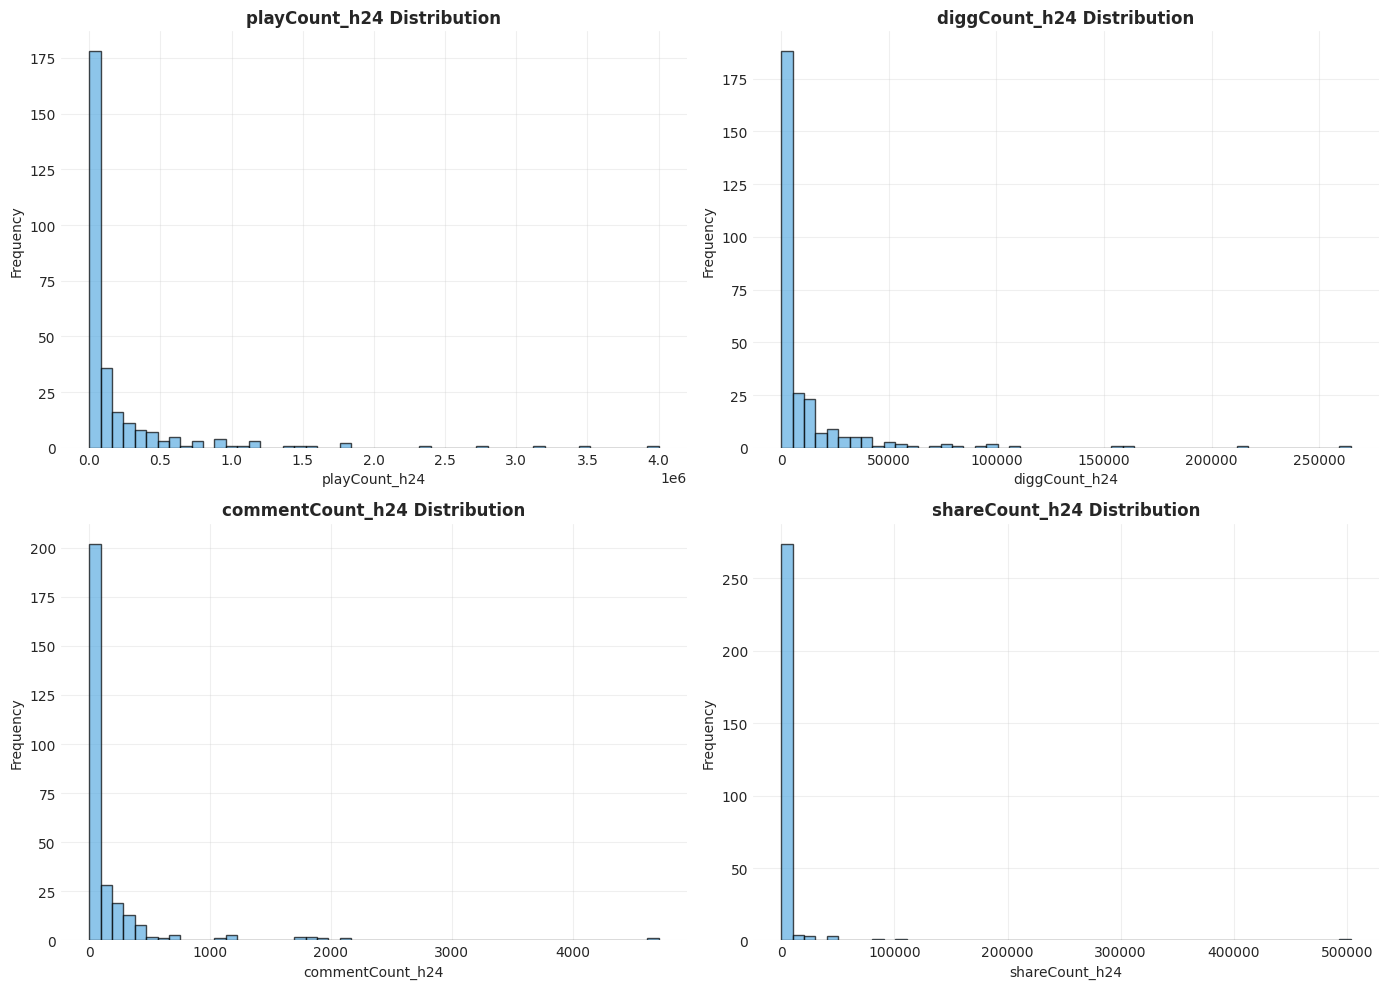

2️⃣ Vẽ phân phối Log (Log-scale Distribution)...


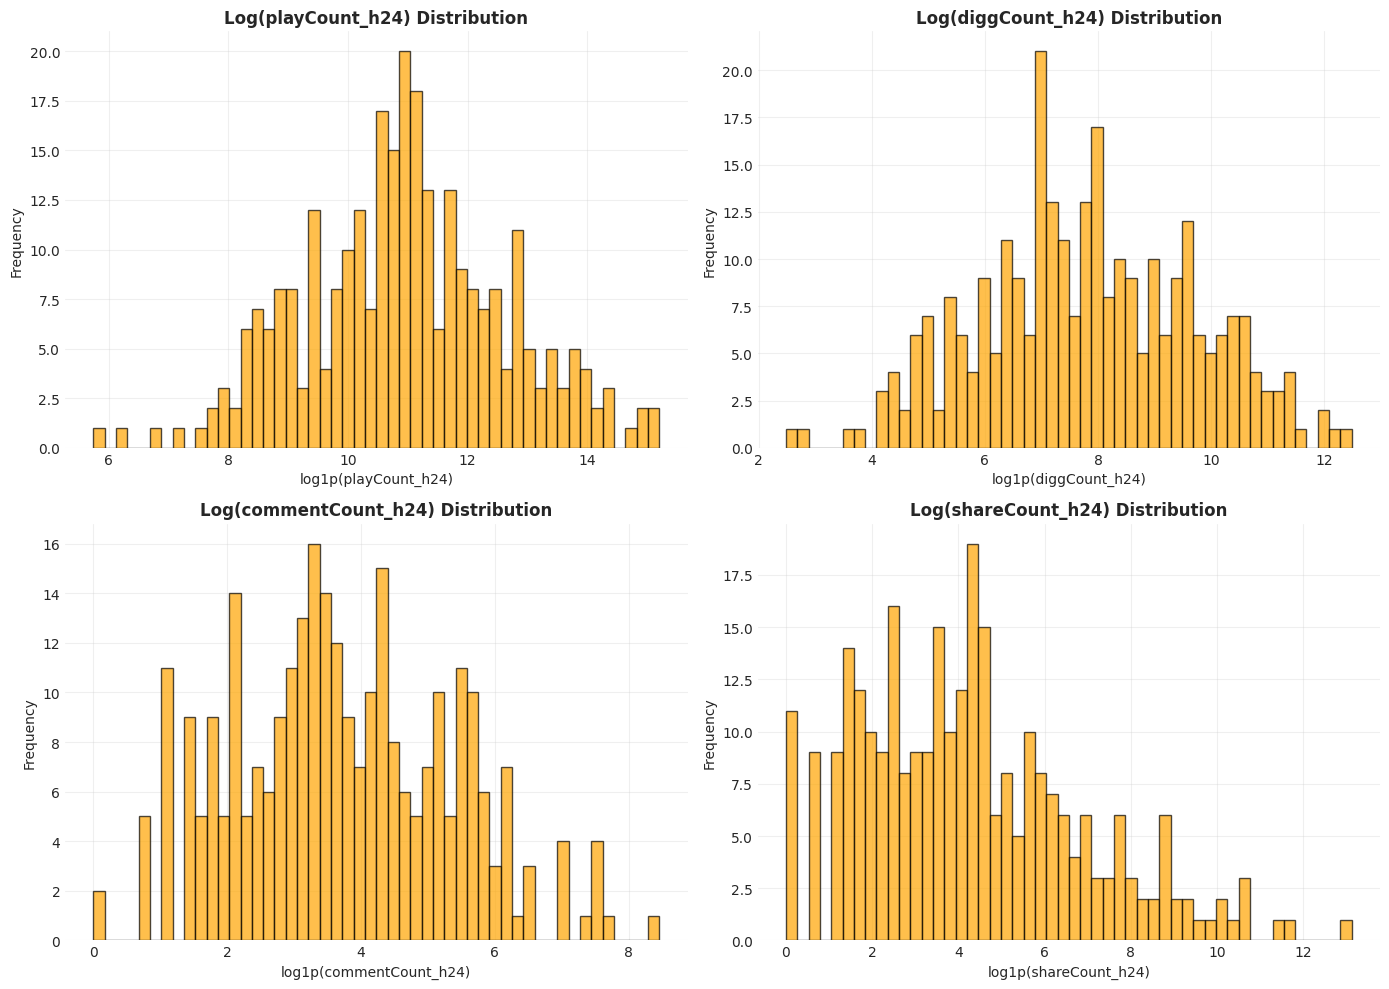

3️⃣ Vẽ Ma trận tương quan (Correlation Heatmap)...


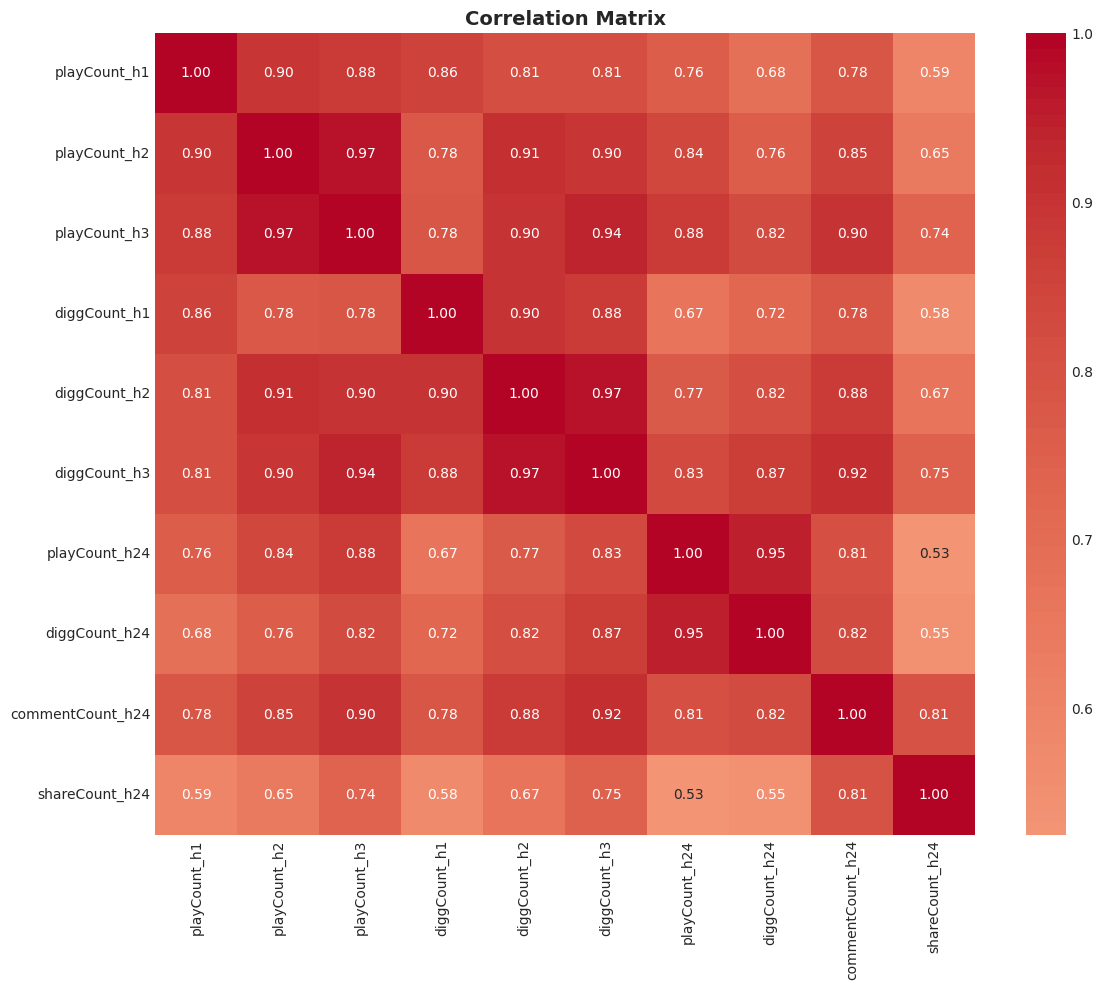

4️⃣ Vẽ Xu hướng tăng trưởng (Growth vs Performance)...


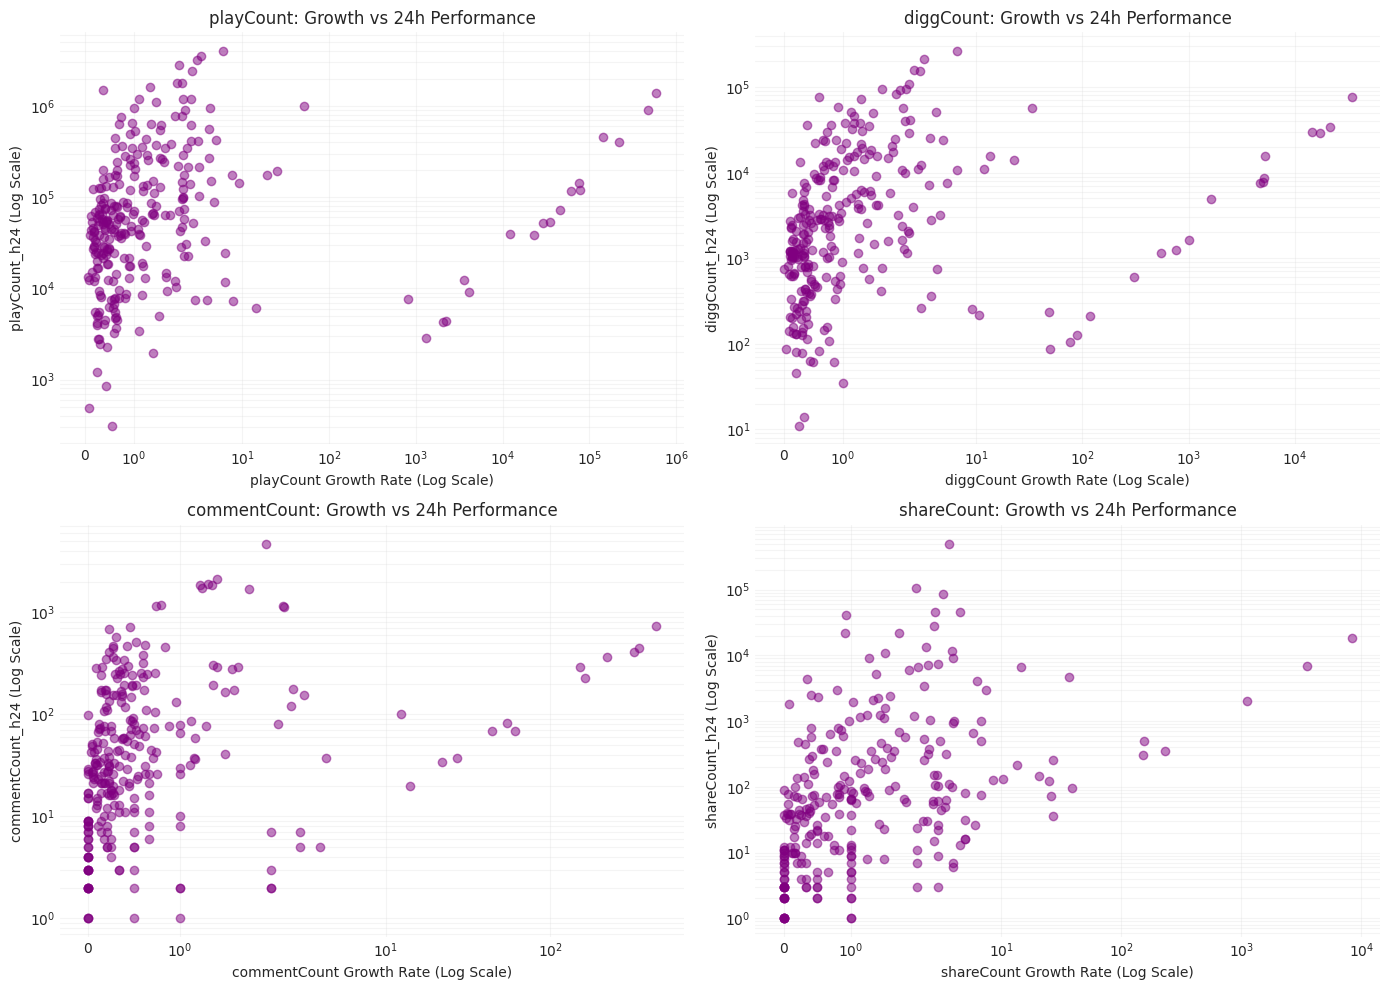

In [7]:
# =============================================================================
# 📊 VISUALIZATION: TARGETS, LOG-SCALE, CORRELATION & GROWTH PATTERNS
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1. CHUẨN BỊ DỮ LIỆU & TÍNH TOÁN CỘT THIẾU
# -----------------------------------------------------------------------------
if 'df_processed' not in locals():
    print("⚠️ Chưa có df_processed, đang lấy từ df_working...")
    if 'df_working' in locals():
        df_viz = df_working.copy()
    else:
        print("❌ Lỗi: Không tìm thấy dữ liệu.")
else:
    df_viz = df_processed.copy()

# Đảm bảo các cột Target h24 tồn tại (nếu trước đó lỡ drop)
targets = ['playCount_h24', 'diggCount_h24', 'commentCount_h24', 'shareCount_h24']
for t in targets:
    if t not in df_viz.columns and 'df_working' in locals():
        df_viz[t] = df_working[t]

# TÍNH LẠI growth_h1_h3 (Bắt buộc cho biểu đồ số 4)
metrics = ['playCount', 'diggCount', 'commentCount', 'shareCount']
for metric in metrics:
    if f'{metric}_h1' in df_viz.columns and f'{metric}_h3' in df_viz.columns:
        # Công thức: (h3 - h1) / (h1 + 1)
        df_viz[f'{metric}_growth_h1_h3'] = (
            (df_viz[f'{metric}_h3'] - df_viz[f'{metric}_h1']) /
            (df_viz[f'{metric}_h1'] + 1)
        )

# Thiết lập style cho đẹp
sns.set_style("whitegrid")

# 2. VẼ BIỂU ĐỒ
# -----------------------------------------------------------------------------

# --- A. Target Distributions (Phân phối thực) ---
print("1️⃣ Vẽ phân phối thực (Raw Distribution)...")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, target in enumerate(targets):
    ax = axes[idx//2, idx%2]
    if target in df_viz.columns:
        ax.hist(df_viz[target], bins=50, edgecolor='black', alpha=0.7, color='#5DADE2')
        ax.set_title(f'{target} Distribution', fontsize=12, fontweight='bold')
        ax.set_xlabel(target)
        ax.set_ylabel('Frequency')
        ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- B. Log-scale Distributions (Phân phối Log - Quan trọng hơn) ---
print("2️⃣ Vẽ phân phối Log (Log-scale Distribution)...")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, target in enumerate(targets):
    ax = axes[idx//2, idx%2]
    if target in df_viz.columns:
        # np.log1p giúp xử lý số 0 mượt mà
        ax.hist(np.log1p(df_viz[target]), bins=50, edgecolor='black', alpha=0.7, color='orange')
        ax.set_title(f'Log({target}) Distribution', fontsize=12, fontweight='bold')
        ax.set_xlabel(f'log1p({target})')
        ax.set_ylabel('Frequency')
        ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- C. Correlation Heatmap ---
print("3️⃣ Vẽ Ma trận tương quan (Correlation Heatmap)...")
# Chỉ chọn các cột thực sự tồn tại để tránh lỗi
potential_cols = ['playCount_h1', 'playCount_h2', 'playCount_h3',
                  'diggCount_h1', 'diggCount_h2', 'diggCount_h3'] + targets
existing_cols = [c for c in potential_cols if c in df_viz.columns]

if len(existing_cols) > 0:
    plt.figure(figsize=(12, 10))
    sns.heatmap(df_viz[existing_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0)
    plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# --- D. Growth Patterns (Biểu đồ chữ L) ---
print("4️⃣ Vẽ Xu hướng tăng trưởng (Growth vs Performance)...")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, metric in enumerate(['playCount', 'diggCount', 'commentCount', 'shareCount']):
    ax = axes[idx//2, idx%2]

    col_growth = f'{metric}_growth_h1_h3'
    col_target = f'{metric}_h24'

    if col_growth in df_viz.columns and col_target in df_viz.columns:
        # Lấy dữ liệu
        x_data = df_viz[col_growth]
        y_data = df_viz[col_target]

        # Vẽ scatter
        ax.scatter(x_data, y_data, alpha=0.5, color='purple')

        # --- PHẦN QUAN TRỌNG NHẤT: CHUYỂN TRỤC LOG ---
        # Dùng symlog (symmetric log) để xử lý được cả số 0 và số âm
        ax.set_xscale('symlog')
        ax.set_yscale('log')

        ax.set_xlabel(f'{metric} Growth Rate (Log Scale)')
        ax.set_ylabel(f'{metric}_h24 (Log Scale)')
        ax.set_title(f'{metric}: Growth vs 24h Performance')
        ax.grid(True, which="both", ls="-", alpha=0.2)
    else:
        ax.text(0.5, 0.5, "Missing Data", ha='center')

plt.tight_layout()
plt.show()

## 🎯 Step 5: Prepare Train/Test Split


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

# =============================================================================
# 1. CHUẨN BỊ X VÀ y (FIXED)
# =============================================================================

# Định nghĩa Target
target_cols = ['playCount_h24', 'diggCount_h24', 'commentCount_h24', 'shareCount_h24']

# --- SỬA LỖI TẠI ĐÂY ---
# Lấy y từ df_working (dữ liệu gốc) vì df_processed đã bị xóa cột h24
# Dùng .loc[df_processed.index] để đảm bảo khớp đúng từng dòng sau khi clean
y = df_working.loc[df_processed.index, target_cols].copy()

# Lấy X từ df_processed (đã clean và chỉ chứa numeric features)
X = df_processed.copy()

# Log transform targets (để giảm variance, giúp model dễ học hơn)
y_log = np.log1p(y)

# Xử lý vô cực/NaN lần cuối cho chắc chắn
X = X.replace([np.inf, -np.inf], 0).fillna(0)

print(f"✅ X shape: {X.shape}")
print(f"✅ y shape: {y.shape}")

# =============================================================================
# 2. TRAIN-TEST SPLIT (STRATIFIED BY VIEW BINS)
# =============================================================================
# Stratify theo tác giả (Author) thường không hiệu quả vì mỗi tác giả có ít video.
# Tốt hơn là Stratify theo "Độ lớn của View" (y_bins) để đảm bảo tập Train và Test
# đều có đủ video View cao và View thấp.

# Tạo bins dựa trên playCount_h24 (chia thành 5 nhóm từ thấp đến cao)
y_bins = pd.qcut(y['playCount_h24'], q=5, labels=False, duplicates='drop')

# Split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in sss.split(X, y_bins):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_log.iloc[train_idx], y_log.iloc[test_idx]

    # Giữ lại giá trị thực (chưa log) để tính toán metrics sau này
    y_train_original, y_test_original = y.iloc[train_idx], y.iloc[test_idx]

# =============================================================================
# 3. SCALE FEATURES
# =============================================================================
print("\n🔄 Scaling Features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert lại thành DataFrame để giữ tên cột (tiện cho việc xem feature importance)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"Train set: {X_train_scaled.shape}")
print(f"Test set:  {X_test_scaled.shape}")

# Kiểm tra xem phân phối View giữa Train và Test có đều không
print("\n📊 Kiểm tra phân phối View trung bình:")
print(f" - Train Mean View: {y_train_original['playCount_h24'].mean():.2f}")
print(f" - Test Mean View:  {y_test_original['playCount_h24'].mean():.2f}")

✅ X shape: (287, 68)
✅ y shape: (287, 4)

🔄 Scaling Features...
Train set: (229, 68)
Test set:  (58, 68)

📊 Kiểm tra phân phối View trung bình:
 - Train Mean View: 211889.07
 - Test Mean View:  243248.09


## 🤖 Step 6: Train XGBoost Models


In [26]:
# =============================================================================
# 🛠️ GLOBAL SETUP: RESTORED (KEEP RAW & LOG)
# =============================================================================

import os
import numpy as np
import pandas as pd
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# 1. CHECK & PREPARE FEATURES (X)
# -----------------------------------------------------------------------------
if 'df_processed' not in locals() or 'df_working' not in locals():
    print("❌ ERROR: Dataframes (df_processed or df_working) not found. Please load data first.")
else:
    print("✅ Raw data found. Preparing features...")

    X = df_processed.copy()

    # Drop non-training columns
    cols_to_exclude = ['video_id', 'author_username', 'create_time', 'actual_hours_h24']
    target_keywords = ['playCount_h24', 'diggCount_h24', 'commentCount_h24', 'shareCount_h24', 'collectCount_h24']
    drop_cols = [c for c in X.columns if c in cols_to_exclude or c in target_keywords]

    X = X.drop(columns=drop_cols, errors='ignore')

    # --- REVERT: Commented out the dropping logic ---
    # We keep both Raw and Log because GBR proved it likes them both.
    # log_cols = [c for c in X.columns if c.endswith('_log')]
    # raw_cols_to_drop = [c.replace('_log', '') for c in log_cols if c.replace('_log', '') in X.columns]
    # if raw_cols_to_drop:
    #     X = X.drop(columns=raw_cols_to_drop)

    X = X.select_dtypes(include=[np.number])
    X = X.replace([np.inf, -np.inf], 0).fillna(0)

    print(f"   🔹 Features Ready: X shape = {X.shape} (Includes Raw + Log)")

    # 2. CONNECT DRIVE & DEFINE PATHS
    # -------------------------------------------------------------------------
    try:
        drive.mount('/content/drive')
        save_path = '/content/drive/My Drive/global_early_signal_prediction/models'
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        print(f"   🔹 Drive Connected. Models will save to: {save_path}")
    except:
        save_path = '.'
        print("   ⚠️ Drive NOT mounted. Models will save to current directory.")

    # 3. DEFINE GLOBAL HELPERS
    # -------------------------------------------------------------------------
    def get_ape_array(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.abs((y_true - y_pred) / (y_true + 1)) * 100

    print("✅ SETUP COMPLETE. Metrics should recover now.")

✅ Raw data found. Preparing features...
   🔹 Features Ready: X shape = (287, 67) (Includes Raw + Log)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   🔹 Drive Connected. Models will save to: /content/drive/My Drive/global_early_signal_prediction/models
✅ SETUP COMPLETE. Metrics should recover now.


In [27]:
# =============================================================================
# 🔍 DATA INSPECTION: FEATURES (X) & TARGETS (y)
# =============================================================================

print("\n📋 FEATURES (X) - Input Columns:")
print("="*60)
print(f"Total Count: {len(X.columns)}")
print("-" * 20)
# Print all columns in a clean list
print(np.array(X.columns))


print("\n\n🎯 TARGETS (y) - Label Columns (from df_working):")
print("="*60)
# These are the columns we excluded from X because they are what we want to predict
target_cols = ['playCount_h24', 'diggCount_h24', 'commentCount_h24', 'shareCount_h24', 'collectCount_h24']
print(target_cols)

print("\n💡 NOTE: Your models are predicting the 'Log Growth' of these targets.")
print("   Formula: y_growth = log1p(Target_h24) - log1p(Target_h3)")


📋 FEATURES (X) - Input Columns:
Total Count: 67
--------------------
['playCount_h1' 'actual_hours_h1' 'diggCount_h1' 'commentCount_h1'
 'shareCount_h1' 'collectCount_h1' 'playCount_h2' 'actual_hours_h2'
 'diggCount_h2' 'commentCount_h2' 'shareCount_h2' 'collectCount_h2'
 'playCount_h3' 'actual_hours_h3' 'diggCount_h3' 'commentCount_h3'
 'shareCount_h3' 'collectCount_h3' 'hour_of_day' 'day_of_week'
 'is_weekend' 'playCount_h1_log' 'playCount_h2_log' 'playCount_h3_log'
 'diggCount_h1_log' 'diggCount_h2_log' 'diggCount_h3_log'
 'commentCount_h1_log' 'commentCount_h2_log' 'commentCount_h3_log'
 'shareCount_h1_log' 'shareCount_h2_log' 'shareCount_h3_log'
 'collectCount_h1_log' 'collectCount_h2_log' 'collectCount_h3_log'
 'playCount_growth_h1_h2' 'playCount_growth_h2_h3'
 'playCount_acceleration' 'diggCount_growth_h1_h2'
 'diggCount_growth_h2_h3' 'diggCount_acceleration'
 'commentCount_growth_h1_h2' 'commentCount_growth_h2_h3'
 'commentCount_acceleration' 'shareCount_growth_h1_h2'
 'shareC

### PURE GBR MODEL

In [28]:
# =============================================================================
# 📦 MODEL 1: SKLEARN GRADIENT BOOSTING (BENCHMARK)
# =============================================================================

import joblib
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# 1. SETUP
# -----------------------------------------------------------------------------
metrics_list = ['playCount', 'diggCount', 'commentCount', 'shareCount']
results_table = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("\n🚀 STARTING SKLEARN GBR TRAINING")
print("="*100)

for metric in metrics_list:
    print(f"📊 Processing: {metric}")

    # --- A. Prepare Targets ---
    col_h3 = df_working.loc[X.index, f'{metric}_h3'].fillna(0)
    col_h24 = df_working.loc[X.index, f'{metric}_h24'].fillna(0)
    col_h24 = np.maximum(col_h24, col_h3)
    y_growth = np.log1p(col_h24) - np.log1p(col_h3)

    # Store metrics per fold
    mean_ape_scores = []
    median_ape_scores = []
    mae_scores = []
    rmse_scores = []
    r2_scores = []

    # --- B. Cross Validation Loop ---
    fold = 1
    for train_idx, test_idx in kf.split(X):
        # Split Data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_growth.iloc[train_idx], y_growth.iloc[test_idx]

        # Train Model
        model = GradientBoostingRegressor(
            n_estimators=500, learning_rate=0.03, max_depth=4,
            loss='absolute_error', random_state=42
        )
        model.fit(X_train, y_train)

        # Predict & Reconstruct
        pred_growth = model.predict(X_test)
        base_h3 = col_h3.iloc[test_idx]
        real_h24 = col_h24.iloc[test_idx]
        pred_h24 = np.maximum(np.expm1(np.log1p(base_h3) + pred_growth), 0)

        # --- Calculate Metrics ---
        # 1. Mean APE
        total_error = np.sum(np.abs(real_h24 - pred_h24))
        total_actual = np.sum(real_h24)
        mean_ape = (total_error / total_actual) * 100 if total_actual != 0 else 0

        # 2. Median APE (Using global helper)
        ape_array = get_ape_array(real_h24, pred_h24)
        median_ape = np.median(ape_array)

        # 3. Standard Metrics
        mae = mean_absolute_error(real_h24, pred_h24)
        rmse = np.sqrt(mean_squared_error(real_h24, pred_h24))
        r2 = r2_score(real_h24, pred_h24)

        # Append
        mean_ape_scores.append(mean_ape)
        median_ape_scores.append(median_ape)
        mae_scores.append(mae)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        fold += 1

    # --- C. Aggregate Results ---
    avg_mean_ape = np.mean(mean_ape_scores)
    avg_median_ape = np.mean(median_ape_scores)
    avg_mae = np.mean(mae_scores)
    avg_rmse = np.mean(rmse_scores)
    avg_r2 = np.mean(r2_scores)

    results_table.append({
        'Metric': metric,
        'Mean APE (%)': avg_mean_ape,
        'Median APE (%)': avg_median_ape,
        'MAE': avg_mae,
        'RMSE': avg_rmse,
        'R2 Score': avg_r2,
    })

    print(f"   ✅ Done. Mean APE={avg_mean_ape:.2f}% | Median APE={avg_median_ape:.2f}% | MAE={avg_mae:.2f} | RMSE={avg_rmse:.2f}")

    # --- D. Retrain & Save ---
    final_model = GradientBoostingRegressor(
        n_estimators=500, learning_rate=0.03, max_depth=4,
        loss='absolute_error', random_state=42
    )
    final_model.fit(X, y_growth)
    joblib.dump(final_model, os.path.join(save_path, f'gbm_growth_{metric}_final.pkl'))

# 2. FINAL REPORT
# -----------------------------------------------------------------------------
print("\n" + "="*120)
print("🏆 SKLEARN GBR RESULTS (5-FOLDS)")
print("="*120)
df_res = pd.DataFrame(results_table)
cols = ['Metric', 'Mean APE (%)', 'Median APE (%)', 'R2 Score', 'MAE', 'RMSE']
print(df_res[cols].round(4).to_string(index=False))


🚀 STARTING SKLEARN GBR TRAINING
📊 Processing: playCount
   ✅ Done. Mean APE=34.25% | Median APE=28.62% | MAE=75520.53 | RMSE=222456.72
📊 Processing: diggCount
   ✅ Done. Mean APE=30.53% | Median APE=23.00% | MAE=3958.67 | RMSE=11747.66
📊 Processing: commentCount
   ✅ Done. Mean APE=21.79% | Median APE=18.48% | MAE=35.79 | RMSE=109.41
📊 Processing: shareCount
   ✅ Done. Mean APE=36.80% | Median APE=35.97% | MAE=1495.39 | RMSE=7833.46

🏆 SKLEARN GBR RESULTS (5-FOLDS)
      Metric  Mean APE (%)  Median APE (%)  R2 Score        MAE        RMSE
   playCount       34.2470         28.6175    0.7836 75520.5252 222456.7230
   diggCount       30.5309         23.0040    0.8223  3958.6705  11747.6567
commentCount       21.7867         18.4814    0.8884    35.7888    109.4118
  shareCount       36.7963         35.9656    0.7578  1495.3941   7833.4650


In [29]:
# =============================================================================
# 🔬 HYBRID EXPERIMENT: LASSO SELECTION -> GBR TRAINING (For Small Data)
# =============================================================================

import joblib
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score

# 1. SETUP
# -----------------------------------------------------------------------------
metrics_list = ['playCount', 'diggCount', 'commentCount', 'shareCount']
comparison_data = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("\n🚀 STARTING HYBRID PIPELINE (Lasso Selection -> GBR)")
print(f"   Note: Dataset size is small (n={len(X)}). Feature reduction is critical.")
print("="*120)

for metric in metrics_list:
    print(f"📊 Metric: {metric}")

    # --- A. Prepare Targets ---
    col_h3 = df_working.loc[X.index, f'{metric}_h3'].fillna(0)
    col_h24 = df_working.loc[X.index, f'{metric}_h24'].fillna(0)
    col_h24 = np.maximum(col_h24, col_h3)
    y_growth = np.log1p(col_h24) - np.log1p(col_h3)

    # --- B. STEP 1: FEATURE SELECTION (Using Lasso) ---
    # We use the whole dataset to select features first (Standard practice for stability analysis)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Strict Alpha to force dropping features
    lasso_selector = Lasso(alpha=0.01, random_state=42)
    lasso_selector.fit(X_scaled, y_growth)

    # Get the "Survivors"
    kept_indices = np.where(lasso_selector.coef_ != 0)[0]
    selected_features = X.columns[kept_indices].tolist()

    # Safety: If Lasso drops everything, keep the top 5 correlations
    if len(selected_features) == 0:
        print("   ⚠️ Lasso dropped everything! Using raw correlation fallback.")
        corrs = X.corrwith(y_growth).abs().sort_values(ascending=False)
        selected_features = corrs.head(10).index.tolist()

    print(f"   ✂️  Reduced Features: {len(X.columns)} -> {len(selected_features)}")

    # Create Subset Data
    X_subset = X[selected_features]

    # --- C. STEP 2: TRAIN GBR ON SUBSET (Cross-Validation) ---
    gbr_full_ape = []
    gbr_hybrid_ape = []

    for train_idx, test_idx in kf.split(X):
        y_train, y_test = y_growth.iloc[train_idx], y_growth.iloc[test_idx]
        base_h3 = col_h3.iloc[test_idx]
        real_h24 = col_h24.iloc[test_idx]

        # 1. GBR on ALL Features (The "Full" Model)
        model_full = GradientBoostingRegressor(n_estimators=500, learning_rate=0.03, max_depth=4, loss='absolute_error', random_state=42)
        model_full.fit(X.iloc[train_idx], y_train)
        pred_full = model_full.predict(X.iloc[test_idx])
        pred_h24_full = np.maximum(np.expm1(np.log1p(base_h3) + pred_full), 0)

        # 2. GBR on SELECTED Features (The "Hybrid" Model)
        model_hybrid = GradientBoostingRegressor(n_estimators=500, learning_rate=0.03, max_depth=4, loss='absolute_error', random_state=42)
        model_hybrid.fit(X_subset.iloc[train_idx], y_train)
        pred_hybrid = model_hybrid.predict(X_subset.iloc[test_idx])
        pred_h24_hybrid = np.maximum(np.expm1(np.log1p(base_h3) + pred_hybrid), 0)

        # Calculate APE
        err_full = np.sum(np.abs(real_h24 - pred_h24_full))
        gbr_full_ape.append((err_full / np.sum(real_h24)) * 100)

        err_hybrid = np.sum(np.abs(real_h24 - pred_h24_hybrid))
        gbr_hybrid_ape.append((err_hybrid / np.sum(real_h24)) * 100)

    # --- D. Compare ---
    mean_full = np.mean(gbr_full_ape)
    mean_hybrid = np.mean(gbr_hybrid_ape)
    diff = mean_full - mean_hybrid # Positive = Hybrid is better (lower error)

    print(f"   🔹 GBR (All {X.shape[1]} Feats): {mean_full:.2f}%")
    print(f"   🔹 GBR (Top {len(selected_features)} Feats): {mean_hybrid:.2f}%")
    print(f"   👉 Improvement: {diff:.2f}%")

    comparison_data.append({
        'Metric': metric,
        'Original Feats': X.shape[1],
        'Selected Feats': len(selected_features),
        'GBR Full APE': mean_full,
        'GBR Hybrid APE': mean_hybrid,
        'Improvement': diff
    })

# 2. FINAL REPORT
# -----------------------------------------------------------------------------
print("\n" + "="*120)
print("🏆 FINAL RESULTS: DOES FEATURE SELECTION HELP?")
print("="*120)

df_res = pd.DataFrame(comparison_data)
df_res['Winner'] = df_res['Improvement'].apply(lambda x: 'Hybrid (Selected)' if x > 0 else 'Full (All Features)')

# Format
df_res['GBR Full APE'] = df_res['GBR Full APE'].round(2).astype(str) + '%'
df_res['GBR Hybrid APE'] = df_res['GBR Hybrid APE'].round(2).astype(str) + '%'
df_res['Improvement'] = df_res['Improvement'].round(2).astype(str) + '%'

print(df_res[['Metric', 'Original Feats', 'Selected Feats', 'Winner', 'GBR Full APE', 'GBR Hybrid APE', 'Improvement']].to_string(index=False))


🚀 STARTING HYBRID PIPELINE (Lasso Selection -> GBR)
   Note: Dataset size is small (n=287). Feature reduction is critical.
📊 Metric: playCount
   ✂️  Reduced Features: 67 -> 17
   🔹 GBR (All 67 Feats): 34.25%
   🔹 GBR (Top 17 Feats): 35.14%
   👉 Improvement: -0.89%
📊 Metric: diggCount
   ✂️  Reduced Features: 67 -> 19
   🔹 GBR (All 67 Feats): 30.53%
   🔹 GBR (Top 19 Feats): 30.09%
   👉 Improvement: 0.44%
📊 Metric: commentCount
   ✂️  Reduced Features: 67 -> 16
   🔹 GBR (All 67 Feats): 21.79%
   🔹 GBR (Top 16 Feats): 20.86%
   👉 Improvement: 0.92%
📊 Metric: shareCount
   ✂️  Reduced Features: 67 -> 18
   🔹 GBR (All 67 Feats): 36.80%
   🔹 GBR (Top 18 Feats): 32.84%
   👉 Improvement: 3.95%

🏆 FINAL RESULTS: DOES FEATURE SELECTION HELP?
      Metric  Original Feats  Selected Feats              Winner GBR Full APE GBR Hybrid APE Improvement
   playCount              67              17 Full (All Features)       34.25%         35.14%      -0.89%
   diggCount              67              19  

### HYBRID LASSO + GBR (WORKED WELL)

In [30]:
# =============================================================================
# 🚀 FINAL PRODUCTION PIPELINE: MIXED STRATEGY
#    - playCount:        Full GBR (All Features)
#    - digg/com/share:   Hybrid (Lasso Selection -> GBR)
# =============================================================================

import joblib
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# 1. DEFINE STRATEGY MAP
# -----------------------------------------------------------------------------
# Based on your experiment results:
strategy_map = {
    'playCount':    'FULL',    # -0.89% (Full was better)
    'diggCount':    'HYBRID',  # +0.44% (Hybrid was better)
    'commentCount': 'HYBRID',  # +0.92% (Hybrid was better)
    'shareCount':   'HYBRID'   # +3.95% (Hybrid was better)
}

print("\n🚀 STARTING FINAL TRAINING WITH MIXED STRATEGY")
print("="*100)

for metric, strategy in strategy_map.items():
    print(f"📊 Metric: {metric:<15} | Strategy: {strategy}")

    # --- A. Prepare Targets ---
    col_h3 = df_working.loc[X.index, f'{metric}_h3'].fillna(0)
    col_h24 = df_working.loc[X.index, f'{metric}_h24'].fillna(0)
    col_h24 = np.maximum(col_h24, col_h3)
    y_growth = np.log1p(col_h24) - np.log1p(col_h3)

    # --- B. EXECUTE STRATEGY ---

    # 1. Identify Features
    if strategy == 'HYBRID':
        # Run Lasso to find best features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        lasso = Lasso(alpha=0.01, random_state=42)
        lasso.fit(X_scaled, y_growth)

        # Get surviving features
        kept_indices = np.where(lasso.coef_ != 0)[0]
        final_features = X.columns[kept_indices].tolist()

        # Safety fallback
        if len(final_features) == 0:
            print("   ⚠️ Lasso dropped all. Fallback to top 10 correlations.")
            corrs = X.corrwith(y_growth).abs().sort_values(ascending=False)
            final_features = corrs.head(10).index.tolist()

        print(f"   ✂️  Feature Selection: Using {len(final_features)}/{len(X.columns)} features.")

    else: # STRATEGY == 'FULL'
        final_features = X.columns.tolist()
        print(f"   📦 Full Mode: Using all {len(final_features)} features.")

    # 2. Train Final GBR on those features
    X_final = X[final_features]

    final_model = GradientBoostingRegressor(
        n_estimators=500, learning_rate=0.03, max_depth=4,
        loss='absolute_error', random_state=42
    )
    final_model.fit(X_final, y_growth)

    # --- C. SAVE EVERYTHING ---
    # We save a dictionary containing the Model AND the Feature List.
    # This is crucial so you know WHICH features to feed it later.
    artifact = {
        'model': final_model,
        'features': final_features,
        'strategy': strategy,
        'metric': metric
    }

    filename = f'final_model_{metric}_{strategy.lower()}.pkl'
    save_full_path = os.path.join(save_path, filename)
    joblib.dump(artifact, save_full_path)

    print(f"   ✅ Saved to: {filename}")
    print("-" * 60)

print("\n🏆 ALL MODELS SAVED SUCCESSFULLY!")
print(f"📂 Location: {save_path}")


🚀 STARTING FINAL TRAINING WITH MIXED STRATEGY
📊 Metric: playCount       | Strategy: FULL
   📦 Full Mode: Using all 67 features.
   ✅ Saved to: final_model_playCount_full.pkl
------------------------------------------------------------
📊 Metric: diggCount       | Strategy: HYBRID
   ✂️  Feature Selection: Using 19/67 features.
   ✅ Saved to: final_model_diggCount_hybrid.pkl
------------------------------------------------------------
📊 Metric: commentCount    | Strategy: HYBRID
   ✂️  Feature Selection: Using 16/67 features.
   ✅ Saved to: final_model_commentCount_hybrid.pkl
------------------------------------------------------------
📊 Metric: shareCount      | Strategy: HYBRID
   ✂️  Feature Selection: Using 18/67 features.
   ✅ Saved to: final_model_shareCount_hybrid.pkl
------------------------------------------------------------

🏆 ALL MODELS SAVED SUCCESSFULLY!
📂 Location: /content/drive/My Drive/global_early_signal_prediction/models


### EXAMPLE INFERENCE LOGIC FOR HYBRID MODELS

In [ ]:
# # Example Inference Logic (Just for reference)
# loaded_artifact = joblib.load('final_model_shareCount_hybrid.pkl')
# model = loaded_artifact['model']
# required_features = loaded_artifact['features']

# # Filter your new data to match the training features automatically
# prediction = model.predict(new_data[required_features])

### COMPARISON SECTION

In [25]:
# =============================================================================
# 📦 UNIFIED MODEL COMPARISON: SKLEARN GBR vs XGBOOST (FULL METRICS)
# =============================================================================

import xgboost as xgb
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# 1. SETUP
# -----------------------------------------------------------------------------
metrics_list = ['playCount', 'diggCount', 'commentCount', 'shareCount']
comparison_data = []

# Define standard k-fold to ensure both models see exact same splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("\n🚀 STARTING UNIFIED TRAINING & COMPARISON (APE, MAE, RMSE)")
print("="*120)

for metric in metrics_list:
    print(f"📊 Metric: {metric}")

    # --- A. Prepare Targets (Shared) ---
    col_h3 = df_working.loc[X.index, f'{metric}_h3'].fillna(0)
    col_h24 = df_working.loc[X.index, f'{metric}_h24'].fillna(0)
    col_h24 = np.maximum(col_h24, col_h3)
    y_growth = np.log1p(col_h24) - np.log1p(col_h3)

    # Storage for this metric
    gbr_ape,  xgb_ape  = [], []
    gbr_mae,  xgb_mae  = [], []
    gbr_rmse, xgb_rmse = [], []
    gbr_r2,   xgb_r2   = [], []

    # --- B. Cross Validation Loop ---
    fold = 1
    for train_idx, test_idx in kf.split(X):
        # Split Data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_growth.iloc[train_idx], y_growth.iloc[test_idx]

        # Real values for validation
        base_h3 = col_h3.iloc[test_idx]
        real_h24 = col_h24.iloc[test_idx]

        # ---------------------------
        # MODEL 1: SKLEARN GBR
        # ---------------------------
        model_gbr = GradientBoostingRegressor(
            n_estimators=500, learning_rate=0.03, max_depth=4,
            loss='absolute_error', random_state=42
        )
        model_gbr.fit(X_train, y_train)

        pred_gbr = model_gbr.predict(X_test)
        pred_h24_gbr = np.maximum(np.expm1(np.log1p(base_h3) + pred_gbr), 0)

        # Metrics GBR
        err_gbr = np.sum(np.abs(real_h24 - pred_h24_gbr))
        tot_gbr = np.sum(real_h24)
        gbr_ape.append((err_gbr / tot_gbr) * 100 if tot_gbr != 0 else 0)
        gbr_mae.append(mean_absolute_error(real_h24, pred_h24_gbr))
        gbr_rmse.append(np.sqrt(mean_squared_error(real_h24, pred_h24_gbr)))
        gbr_r2.append(r2_score(real_h24, pred_h24_gbr))

        # ---------------------------
        # MODEL 2: XGBOOST
        # ---------------------------
        model_xgb = xgb.XGBRegressor(
            n_estimators=500, learning_rate=0.03, max_depth=4,
            objective='reg:absoluteerror', n_jobs=-1,
            random_state=42, tree_method='hist'
        )
        model_xgb.fit(X_train, y_train)

        pred_xgb = model_xgb.predict(X_test)
        pred_h24_xgb = np.maximum(np.expm1(np.log1p(base_h3) + pred_xgb), 0)

        # Metrics XGB
        err_xgb = np.sum(np.abs(real_h24 - pred_h24_xgb))
        tot_xgb = np.sum(real_h24)
        xgb_ape.append((err_xgb / tot_xgb) * 100 if tot_xgb != 0 else 0)
        xgb_mae.append(mean_absolute_error(real_h24, pred_h24_xgb))
        xgb_rmse.append(np.sqrt(mean_squared_error(real_h24, pred_h24_xgb)))
        xgb_r2.append(r2_score(real_h24, pred_h24_xgb))

        fold += 1

    # --- C. Compare & Aggregate ---
    # APE
    mean_ape_gbr = np.mean(gbr_ape)
    mean_ape_xgb = np.mean(xgb_ape)
    diff_ape = mean_ape_gbr - mean_ape_xgb # Positive = XGB wins

    # MAE
    mean_mae_gbr = np.mean(gbr_mae)
    mean_mae_xgb = np.mean(xgb_mae)
    diff_mae = mean_mae_gbr - mean_mae_xgb

    # RMSE
    mean_rmse_gbr = np.mean(gbr_rmse)
    mean_rmse_xgb = np.mean(xgb_rmse)
    diff_rmse = mean_rmse_gbr - mean_rmse_xgb

    print(f"   🔹 GBR Mean APE: {mean_ape_gbr:.2f}% | MAE: {mean_mae_gbr:.0f}")
    print(f"   🔹 XGB Mean APE: {mean_ape_xgb:.2f}% | MAE: {mean_mae_xgb:.0f}")
    print(f"   👉 APE Diff: {diff_ape:.2f}% ({'XGB Wins' if diff_ape > 0 else 'GBR Wins'})")

    comparison_data.append({
        'Metric': metric,
        # APE
        'GBR Mean APE': mean_ape_gbr,
        'XGB Mean APE': mean_ape_xgb,
        'Diff APE': diff_ape,
        # MAE
        'GBR MAE': mean_mae_gbr,
        'XGB MAE': mean_mae_xgb,
        'Diff MAE': diff_mae,
        # RMSE
        'GBR RMSE': mean_rmse_gbr,
        'XGB RMSE': mean_rmse_xgb,
        'Diff RMSE': diff_rmse,
        # R2
        'GBR R2': np.mean(gbr_r2),
        'XGB R2': np.mean(xgb_r2)
    })

    # --- D. Train Final Models & Save ---
    final_gbr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.03, max_depth=4, loss='absolute_error', random_state=42)
    final_gbr.fit(X, y_growth)
    joblib.dump(final_gbr, os.path.join(save_path, f'gbr_growth_{metric}_final.pkl'))

    final_xgb = xgb.XGBRegressor(n_estimators=500, learning_rate=0.03, max_depth=4, objective='reg:absoluteerror', n_jobs=-1, random_state=42, tree_method='hist')
    final_xgb.fit(X, y_growth)
    joblib.dump(final_xgb, os.path.join(save_path, f'xgboost_growth_{metric}_final.pkl'))

# 2. FINAL PIVOT TABLE REPORT
# -----------------------------------------------------------------------------
print("\n" + "="*140)
print("🏆 FINAL SIDE-BY-SIDE COMPARISON (APE, MAE, RMSE)")
print("="*140)

df_comp = pd.DataFrame(comparison_data)

# Select Columns
cols = [
    'Metric',
    'GBR Mean APE', 'XGB Mean APE', 'Diff APE',
    'GBR MAE', 'XGB MAE', 'Diff MAE',
    'GBR RMSE', 'XGB RMSE', 'Diff RMSE'
]
df_view = df_comp[cols].copy()

# Add Winner based on APE (Primary metric)
df_view.insert(1, 'Winner', df_view['Diff APE'].apply(lambda x: 'XGBoost' if x > 0 else 'Sklearn GBR'))

# Formatting
# APE -> %
df_view['GBR Mean APE'] = df_view['GBR Mean APE'].round(2).astype(str) + '%'
df_view['XGB Mean APE'] = df_view['XGB Mean APE'].round(2).astype(str) + '%'
df_view['Diff APE']     = df_view['Diff APE'].round(2).astype(str) + '%'

# MAE/RMSE -> Standard Numbers (No decimals for large counts)
df_view['GBR MAE']  = df_view['GBR MAE'].round(1)
df_view['XGB MAE']  = df_view['XGB MAE'].round(1)
df_view['Diff MAE'] = df_view['Diff MAE'].round(1)

df_view['GBR RMSE']  = df_view['GBR RMSE'].round(1)
df_view['XGB RMSE']  = df_view['XGB RMSE'].round(1)
df_view['Diff RMSE'] = df_view['Diff RMSE'].round(1)

# Display Full Table
print(df_view.to_string(index=False))


🚀 STARTING UNIFIED TRAINING & COMPARISON (APE, MAE, RMSE)
📊 Metric: playCount
   🔹 GBR Mean APE: 36.09% | MAE: 80399
   🔹 XGB Mean APE: 37.20% | MAE: 82785
   👉 APE Diff: -1.11% (GBR Wins)
📊 Metric: diggCount
   🔹 GBR Mean APE: 31.64% | MAE: 4116
   🔹 XGB Mean APE: 33.57% | MAE: 4379
   👉 APE Diff: -1.92% (GBR Wins)
📊 Metric: commentCount
   🔹 GBR Mean APE: 22.35% | MAE: 37
   🔹 XGB Mean APE: 23.52% | MAE: 40
   👉 APE Diff: -1.17% (GBR Wins)
📊 Metric: shareCount
   🔹 GBR Mean APE: 36.21% | MAE: 1267
   🔹 XGB Mean APE: 42.34% | MAE: 2086
   👉 APE Diff: -6.13% (GBR Wins)

🏆 FINAL SIDE-BY-SIDE COMPARISON (APE, MAE, RMSE)
      Metric      Winner GBR Mean APE XGB Mean APE Diff APE  GBR MAE  XGB MAE  Diff MAE  GBR RMSE  XGB RMSE  Diff RMSE
   playCount Sklearn GBR       36.09%        37.2%   -1.11%  80399.4  82785.2   -2385.8  236495.7  244276.5    -7780.8
   diggCount Sklearn GBR       31.64%       33.57%   -1.92%   4116.3   4378.5    -262.2   12620.1   14160.3    -1540.2
commentCount Skl

In [18]:
# =============================================================================
# 📦 UNIFIED MODEL COMPARISON: SKLEARN GBR vs ELASTICNET (FULL METRICS)
# =============================================================================

import joblib
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# 1. SETUP
# -----------------------------------------------------------------------------
metrics_list = ['playCount', 'diggCount', 'commentCount', 'shareCount']
comparison_data = []

# Define standard k-fold to ensure both models see exact same splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("\n🚀 STARTING GBR vs ELASTICNET COMPARISON (APE, MAE, RMSE)")
print("="*120)

for metric in metrics_list:
    print(f"📊 Metric: {metric}")

    # --- A. Prepare Targets (Shared) ---
    col_h3 = df_working.loc[X.index, f'{metric}_h3'].fillna(0)
    col_h24 = df_working.loc[X.index, f'{metric}_h24'].fillna(0)
    col_h24 = np.maximum(col_h24, col_h3)
    y_growth = np.log1p(col_h24) - np.log1p(col_h3)

    # Storage for this metric
    gbr_ape,  enet_ape  = [], []
    gbr_mae,  enet_mae  = [], []
    gbr_rmse, enet_rmse = [], []
    gbr_r2,   enet_r2   = [], []

    # --- B. Cross Validation Loop ---
    fold = 1
    for train_idx, test_idx in kf.split(X):
        # Split Data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_growth.iloc[train_idx], y_growth.iloc[test_idx]

        # Real values for validation
        base_h3 = col_h3.iloc[test_idx]
        real_h24 = col_h24.iloc[test_idx]

        # ---------------------------
        # MODEL 1: SKLEARN GBR (Tree-based)
        # ---------------------------
        model_gbr = GradientBoostingRegressor(
            n_estimators=500, learning_rate=0.03, max_depth=4,
            loss='absolute_error', random_state=42
        )
        model_gbr.fit(X_train, y_train)

        pred_gbr = model_gbr.predict(X_test)
        pred_h24_gbr = np.maximum(np.expm1(np.log1p(base_h3) + pred_gbr), 0)

        # Metrics GBR
        err_gbr = np.sum(np.abs(real_h24 - pred_h24_gbr))
        tot_gbr = np.sum(real_h24)
        gbr_ape.append((err_gbr / tot_gbr) * 100 if tot_gbr != 0 else 0)
        gbr_mae.append(mean_absolute_error(real_h24, pred_h24_gbr))
        gbr_rmse.append(np.sqrt(mean_squared_error(real_h24, pred_h24_gbr)))
        gbr_r2.append(r2_score(real_h24, pred_h24_gbr))

        # ---------------------------
        # MODEL 2: ELASTICNET (Linear)
        # ---------------------------
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        model_enet = ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42)
        model_enet.fit(X_train_scaled, y_train)

        pred_enet = model_enet.predict(X_test_scaled)
        pred_h24_enet = np.maximum(np.expm1(np.log1p(base_h3) + pred_enet), 0)

        # Metrics ElasticNet
        err_enet = np.sum(np.abs(real_h24 - pred_h24_enet))
        tot_enet = np.sum(real_h24)
        enet_ape.append((err_enet / tot_enet) * 100 if tot_enet != 0 else 0)
        enet_mae.append(mean_absolute_error(real_h24, pred_h24_enet))
        enet_rmse.append(np.sqrt(mean_squared_error(real_h24, pred_h24_enet)))
        enet_r2.append(r2_score(real_h24, pred_h24_enet))

        fold += 1

    # --- C. Compare & Aggregate ---
    # APE
    mean_ape_gbr = np.mean(gbr_ape)
    mean_ape_enet = np.mean(enet_ape)
    diff_ape = mean_ape_gbr - mean_ape_enet # Positive = ENet wins

    # MAE
    mean_mae_gbr = np.mean(gbr_mae)
    mean_mae_enet = np.mean(enet_mae)
    diff_mae = mean_mae_gbr - mean_mae_enet

    # RMSE
    mean_rmse_gbr = np.mean(gbr_rmse)
    mean_rmse_enet = np.mean(enet_rmse)
    diff_rmse = mean_rmse_gbr - mean_rmse_enet

    print(f"   🔹 GBR Mean APE:  {mean_ape_gbr:.2f}% | MAE: {mean_mae_gbr:.0f}")
    print(f"   🔹 ENet Mean APE: {mean_ape_enet:.2f}% | MAE: {mean_mae_enet:.0f}")
    print(f"   👉 Gap: {diff_ape:.2f}% ({'ENet Wins' if diff_ape > 0 else 'GBR Wins'})")

    comparison_data.append({
        'Metric': metric,
        # APE
        'GBR Mean APE': mean_ape_gbr,
        'ENet Mean APE': mean_ape_enet,
        'Diff APE': diff_ape,
        # MAE
        'GBR MAE': mean_mae_gbr,
        'ENet MAE': mean_mae_enet,
        'Diff MAE': diff_mae,
        # RMSE
        'GBR RMSE': mean_rmse_gbr,
        'ENet RMSE': mean_rmse_enet,
        'Diff RMSE': diff_rmse,
        # R2
        'GBR R2': np.mean(gbr_r2),
        'ENet R2': np.mean(enet_r2)
    })

    # --- D. Train Final Models & Save ---
    # 1. Save GBR
    final_gbr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.03, max_depth=4, loss='absolute_error', random_state=42)
    final_gbr.fit(X, y_growth)
    joblib.dump(final_gbr, os.path.join(save_path, f'gbr_growth_{metric}_final.pkl'))

    # 2. Save ElasticNet (AND Scaler)
    final_scaler = StandardScaler()
    X_scaled_full = final_scaler.fit_transform(X)

    final_enet = ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42)
    final_enet.fit(X_scaled_full, y_growth)

    joblib.dump(final_enet, os.path.join(save_path, f'elasticnet_growth_{metric}_model.pkl'))
    joblib.dump(final_scaler, os.path.join(save_path, f'elasticnet_growth_{metric}_scaler.pkl'))

# 2. FINAL PIVOT TABLE REPORT
# -----------------------------------------------------------------------------
print("\n" + "="*140)
print("🏆 FINAL COMPARISON: GBR vs ELASTICNET (APE, MAE, RMSE)")
print("="*140)

df_comp = pd.DataFrame(comparison_data)

# Select Columns
cols = [
    'Metric',
    'GBR Mean APE', 'ENet Mean APE', 'Diff APE',
    'GBR MAE', 'ENet MAE', 'Diff MAE',
    'GBR RMSE', 'ENet RMSE', 'Diff RMSE'
]
df_view = df_comp[cols].copy()

# Add Winner based on APE
df_view.insert(1, 'Winner', df_view['Diff APE'].apply(lambda x: 'ElasticNet' if x > 0 else 'Sklearn GBR'))

# Formatting
# APE -> %
df_view['GBR Mean APE']  = df_view['GBR Mean APE'].round(2).astype(str) + '%'
df_view['ENet Mean APE'] = df_view['ENet Mean APE'].round(2).astype(str) + '%'
df_view['Diff APE']      = df_view['Diff APE'].round(2).astype(str) + '%'

# MAE/RMSE -> Standard Numbers
df_view['GBR MAE']   = df_view['GBR MAE'].round(1)
df_view['ENet MAE']  = df_view['ENet MAE'].round(1)
df_view['Diff MAE']  = df_view['Diff MAE'].round(1)

df_view['GBR RMSE']  = df_view['GBR RMSE'].round(1)
df_view['ENet RMSE'] = df_view['ENet RMSE'].round(1)
df_view['Diff RMSE'] = df_view['Diff RMSE'].round(1)

print(df_view.to_string(index=False))


🚀 STARTING GBR vs ELASTICNET COMPARISON (APE, MAE, RMSE)
📊 Metric: playCount
   🔹 GBR Mean APE:  34.25% | MAE: 75521
   🔹 ENet Mean APE: 45.48% | MAE: 103927
   👉 Gap: -11.23% (GBR Wins)
📊 Metric: diggCount
   🔹 GBR Mean APE:  30.53% | MAE: 3959
   🔹 ENet Mean APE: 43.97% | MAE: 5876
   👉 Gap: -13.44% (GBR Wins)
📊 Metric: commentCount
   🔹 GBR Mean APE:  21.79% | MAE: 36
   🔹 ENet Mean APE: 22.89% | MAE: 36
   👉 Gap: -1.11% (GBR Wins)
📊 Metric: shareCount
   🔹 GBR Mean APE:  36.80% | MAE: 1495
   🔹 ENet Mean APE: 56.67% | MAE: 2659
   👉 Gap: -19.87% (GBR Wins)

🏆 FINAL COMPARISON: GBR vs ELASTICNET (APE, MAE, RMSE)
      Metric      Winner GBR Mean APE ENet Mean APE Diff APE  GBR MAE  ENet MAE  Diff MAE  GBR RMSE  ENet RMSE  Diff RMSE
   playCount Sklearn GBR       34.25%        45.48%  -11.23%  75520.5  103926.8  -28406.3  222456.7   324404.1  -101947.4
   diggCount Sklearn GBR       30.53%        43.97%  -13.44%   3958.7    5875.6   -1917.0   11747.7    18782.3    -7034.6
commentCou

### USE LASSO TO POINT OUT WHETHER FEATURE ENGINEERING WORK

In [19]:
# =============================================================================
# 📦 UNIFIED MODEL COMPARISON: SKLEARN GBR vs LASSO (FULL METRICS + FEATURE DROP)
# =============================================================================

import joblib
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# 1. SETUP
# -----------------------------------------------------------------------------
metrics_list = ['playCount', 'diggCount', 'commentCount', 'shareCount']
comparison_data = []

# Define standard k-fold to ensure both models see exact same splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("\n🚀 STARTING GBR vs LASSO COMPARISON (APE, MAE, RMSE)")
print("="*120)

for metric in metrics_list:
    print(f"📊 Metric: {metric}")

    # --- A. Prepare Targets (Shared) ---
    col_h3 = df_working.loc[X.index, f'{metric}_h3'].fillna(0)
    col_h24 = df_working.loc[X.index, f'{metric}_h24'].fillna(0)
    col_h24 = np.maximum(col_h24, col_h3)
    y_growth = np.log1p(col_h24) - np.log1p(col_h3)

    # Storage for this metric
    gbr_ape,  lasso_ape  = [], []
    gbr_mae,  lasso_mae  = [], []
    gbr_rmse, lasso_rmse = [], []
    gbr_r2,   lasso_r2   = [], []

    # Store zero-weight count to see how many features Lasso dropped
    dropped_feats_count = []

    # --- B. Cross Validation Loop ---
    fold = 1
    for train_idx, test_idx in kf.split(X):
        # Split Data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y_growth.iloc[train_idx], y_growth.iloc[test_idx]

        # Real values for validation
        base_h3 = col_h3.iloc[test_idx]
        real_h24 = col_h24.iloc[test_idx]

        # ---------------------------
        # MODEL 1: SKLEARN GBR
        # ---------------------------
        model_gbr = GradientBoostingRegressor(
            n_estimators=500, learning_rate=0.03, max_depth=4,
            loss='absolute_error', random_state=42
        )
        model_gbr.fit(X_train, y_train)

        pred_gbr = model_gbr.predict(X_test)
        pred_h24_gbr = np.maximum(np.expm1(np.log1p(base_h3) + pred_gbr), 0)

        # Metrics GBR
        err_gbr = np.sum(np.abs(real_h24 - pred_h24_gbr))
        tot_gbr = np.sum(real_h24)
        gbr_ape.append((err_gbr / tot_gbr) * 100 if tot_gbr != 0 else 0)
        gbr_mae.append(mean_absolute_error(real_h24, pred_h24_gbr))
        gbr_rmse.append(np.sqrt(mean_squared_error(real_h24, pred_h24_gbr)))
        gbr_r2.append(r2_score(real_h24, pred_h24_gbr))

        # ---------------------------
        # MODEL 2: LASSO (Feature Selector)
        # ---------------------------
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)

        # Alpha=0.01 is a balanced starting point.
        # Increase to 0.05 or 0.1 if you want it to be MORE aggressive at dropping features.
        model_lasso = Lasso(alpha=0.01, random_state=42)
        model_lasso.fit(X_train_scaled, y_train)

        # Check how many features were dropped (weight == 0)
        n_dropped = np.sum(model_lasso.coef_ == 0)
        dropped_feats_count.append(n_dropped)

        pred_lasso = model_lasso.predict(X_test_scaled)
        pred_h24_lasso = np.maximum(np.expm1(np.log1p(base_h3) + pred_lasso), 0)

        # Metrics Lasso
        err_lasso = np.sum(np.abs(real_h24 - pred_h24_lasso))
        tot_lasso = np.sum(real_h24)
        lasso_ape.append((err_lasso / tot_lasso) * 100 if tot_lasso != 0 else 0)
        lasso_mae.append(mean_absolute_error(real_h24, pred_h24_lasso))
        lasso_rmse.append(np.sqrt(mean_squared_error(real_h24, pred_h24_lasso)))
        lasso_r2.append(r2_score(real_h24, pred_h24_lasso))

        fold += 1

    # --- C. Compare & Aggregate ---
    # APE
    mean_ape_gbr = np.mean(gbr_ape)
    mean_ape_lasso = np.mean(lasso_ape)
    diff_ape = mean_ape_gbr - mean_ape_lasso # Positive = Lasso wins

    # MAE
    mean_mae_gbr = np.mean(gbr_mae)
    mean_mae_lasso = np.mean(lasso_mae)
    diff_mae = mean_mae_gbr - mean_mae_lasso

    # RMSE
    mean_rmse_gbr = np.mean(gbr_rmse)
    mean_rmse_lasso = np.mean(lasso_rmse)
    diff_rmse = mean_rmse_gbr - mean_rmse_lasso

    # Feature Drop Stats
    avg_dropped = np.mean(dropped_feats_count)
    total_feats = X.shape[1]

    print(f"   🔹 GBR Mean APE:   {mean_ape_gbr:.2f}%")
    print(f"   🔹 Lasso Mean APE: {mean_ape_lasso:.2f}%")
    print(f"   ✂️  Lasso dropped ~{int(avg_dropped)}/{total_feats} features.")
    print(f"   👉 Gap: {diff_ape:.2f}% ({'Lasso Wins' if diff_ape > 0 else 'GBR Wins'})")

    comparison_data.append({
        'Metric': metric,
        # APE
        'GBR Mean APE': mean_ape_gbr,
        'Lasso Mean APE': mean_ape_lasso,
        'Diff APE': diff_ape,
        'Dropped Feats': f"{int(avg_dropped)}/{total_feats}",
        # MAE
        'GBR MAE': mean_mae_gbr,
        'Lasso MAE': mean_mae_lasso,
        'Diff MAE': diff_mae,
        # RMSE
        'GBR RMSE': mean_rmse_gbr,
        'Lasso RMSE': mean_rmse_lasso,
        'Diff RMSE': diff_rmse,
    })

    # --- D. Train Final Models & Save ---
    # 1. Save GBR
    final_gbr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.03, max_depth=4, loss='absolute_error', random_state=42)
    final_gbr.fit(X, y_growth)
    joblib.dump(final_gbr, os.path.join(save_path, f'gbr_growth_{metric}_final.pkl'))

    # 2. Save Lasso (AND Scaler)
    final_scaler = StandardScaler()
    X_scaled_full = final_scaler.fit_transform(X)

    final_lasso = Lasso(alpha=0.01, random_state=42)
    final_lasso.fit(X_scaled_full, y_growth)

    joblib.dump(final_lasso, os.path.join(save_path, f'lasso_growth_{metric}_model.pkl'))
    joblib.dump(final_scaler, os.path.join(save_path, f'lasso_growth_{metric}_scaler.pkl'))

# 2. FINAL PIVOT TABLE REPORT
# -----------------------------------------------------------------------------
print("\n" + "="*140)
print("🏆 FINAL COMPARISON: GBR vs LASSO (Feature Check)")
print("="*140)

df_comp = pd.DataFrame(comparison_data)

# Select Columns
cols = [
    'Metric',
    'GBR Mean APE', 'Lasso Mean APE', 'Diff APE', 'Dropped Feats',
    'GBR MAE', 'Lasso MAE', 'Diff MAE',
    'GBR RMSE', 'Lasso RMSE', 'Diff RMSE'
]
df_view = df_comp[cols].copy()

# Add Winner
df_view.insert(1, 'Winner', df_view['Diff APE'].apply(lambda x: 'Lasso' if x > 0 else 'Sklearn GBR'))

# Formatting
df_view['GBR Mean APE']   = df_view['GBR Mean APE'].round(2).astype(str) + '%'
df_view['Lasso Mean APE'] = df_view['Lasso Mean APE'].round(2).astype(str) + '%'
df_view['Diff APE']       = df_view['Diff APE'].round(2).astype(str) + '%'

df_view['GBR MAE']    = df_view['GBR MAE'].round(1)
df_view['Lasso MAE']  = df_view['Lasso MAE'].round(1)
df_view['Diff MAE']   = df_view['Diff MAE'].round(1)

df_view['GBR RMSE']   = df_view['GBR RMSE'].round(1)
df_view['Lasso RMSE'] = df_view['Lasso RMSE'].round(1)
df_view['Diff RMSE']  = df_view['Diff RMSE'].round(1)

print(df_view.to_string(index=False))


🚀 STARTING GBR vs LASSO COMPARISON (APE, MAE, RMSE)
📊 Metric: playCount
   🔹 GBR Mean APE:   34.25%
   🔹 Lasso Mean APE: 40.87%
   ✂️  Lasso dropped ~48/67 features.
   👉 Gap: -6.63% (GBR Wins)
📊 Metric: diggCount
   🔹 GBR Mean APE:   30.53%
   🔹 Lasso Mean APE: 40.14%
   ✂️  Lasso dropped ~47/67 features.
   👉 Gap: -9.61% (GBR Wins)
📊 Metric: commentCount
   🔹 GBR Mean APE:   21.79%
   🔹 Lasso Mean APE: 20.67%
   ✂️  Lasso dropped ~52/67 features.
   👉 Gap: 1.11% (Lasso Wins)
📊 Metric: shareCount
   🔹 GBR Mean APE:   36.80%
   🔹 Lasso Mean APE: 44.19%
   ✂️  Lasso dropped ~48/67 features.
   👉 Gap: -7.39% (GBR Wins)

🏆 FINAL COMPARISON: GBR vs LASSO (Feature Check)
      Metric      Winner GBR Mean APE Lasso Mean APE Diff APE Dropped Feats  GBR MAE  Lasso MAE  Diff MAE  GBR RMSE  Lasso RMSE  Diff RMSE
   playCount Sklearn GBR       34.25%         40.87%   -6.63%         48/67  75520.5    90845.3  -15324.8  222456.7    268200.4   -45743.7
   diggCount Sklearn GBR       30.53%         

In [20]:
# =============================================================================
# 🔍 FEATURE INSPECTION: LASSO COEFFICIENTS (KEEP vs DROP)
# =============================================================================

import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# 1. SETUP
# -----------------------------------------------------------------------------
# We will inspect the 'commentCount' model (since Lasso actually won there)
# and 'playCount' (to see why GBR won).
metrics_to_inspect = ['playCount', 'commentCount']

print("\n🚀 ANALYZING LASSO FEATURE IMPORTANCE")
print("="*100)

for metric in metrics_to_inspect:
    print(f"\n📊 METRIC: {metric}")

    # --- A. Prepare Data (Same as before) ---
    col_h3 = df_working.loc[X.index, f'{metric}_h3'].fillna(0)
    col_h24 = df_working.loc[X.index, f'{metric}_h24'].fillna(0)
    col_h24 = np.maximum(col_h24, col_h3)
    y_growth = np.log1p(col_h24) - np.log1p(col_h3)

    # --- B. Train Lasso on FULL Data ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Use the same alpha as the comparison
    lasso = Lasso(alpha=0.01, random_state=42)
    lasso.fit(X_scaled, y_growth)

    # --- C. Extract Coefficients ---
    coefs = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': lasso.coef_,
        'Abs_Coef': np.abs(lasso.coef_)
    })

    # --- D. Split into Kept vs Dropped ---
    # Dropped = Coefficient is exactly 0
    dropped = coefs[coefs['Coefficient'] == 0]
    # Kept = Coefficient is NOT 0
    kept = coefs[coefs['Coefficient'] != 0].sort_values(by='Abs_Coef', ascending=False)

    # --- E. Report ---
    print(f"   ✅ Kept: {len(kept)} features")
    print(f"   ❌ Dropped: {len(dropped)} features")

    print("\n   🏆 TOP 10 MOST IMPORTANT FEATURES (Lasso Kept):")
    print(kept[['Feature', 'Coefficient']].head(10).to_string(index=False))

    print("\n   🗑️  SAMPLE OF DROPPED FEATURES (Lasso Killed):")
    # Show first 10 dropped to give you an idea
    print(dropped['Feature'].head(15).tolist())
    print("-" * 80)


🚀 ANALYZING LASSO FEATURE IMPORTANCE

📊 METRIC: playCount
   ✅ Kept: 17 features
   ❌ Dropped: 50 features

   🏆 TOP 10 MOST IMPORTANT FEATURES (Lasso Kept):
              Feature  Coefficient
  collectCount_h2_log    -0.267373
playCount_velocity_h3     0.174578
        shareCount_h2    -0.158891
     playCount_h3_log    -0.146462
    shareCount_h3_log     0.140969
      comment_rate_h2     0.112185
diggCount_velocity_h2     0.086953
         digg_rate_h1     0.045861
          hour_of_day     0.034856
diggCount_velocity_h3     0.034807

   🗑️  SAMPLE OF DROPPED FEATURES (Lasso Killed):
['playCount_h1', 'diggCount_h1', 'commentCount_h1', 'collectCount_h1', 'playCount_h2', 'diggCount_h2', 'commentCount_h2', 'playCount_h3', 'diggCount_h3', 'commentCount_h3', 'shareCount_h3', 'collectCount_h3', 'day_of_week', 'playCount_h1_log', 'playCount_h2_log']
--------------------------------------------------------------------------------

📊 METRIC: commentCount
   ✅ Kept: 16 features
   ❌ Dropped:

In [14]:
# =============================================================================
# 📦 FINAL PIPELINE: RIDGE REGRESSION (L2) WITH SCALING & K-FOLD CV
# =============================================================================

import os
import joblib
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

# 1. KIỂM TRA DỮ LIỆU
# -----------------------------------------------------------------------------
if 'df_processed' not in locals() or 'df_working' not in locals():
    print("❌ LỖI: Không tìm thấy dữ liệu (df_processed hoặc df_working).")
else:
    # 2. CHUẨN BỊ FEATURES (X)
    # -------------------------------------------------------------------------
    X = df_processed.copy()

    # Loại bỏ các cột không dùng train
    cols_to_exclude = ['video_id', 'author_username', 'create_time', 'actual_hours_h24']
    target_keywords = ['playCount_h24', 'diggCount_h24', 'commentCount_h24', 'shareCount_h24', 'collectCount_h24']
    drop_cols = [c for c in X.columns if c in cols_to_exclude or c in target_keywords]
    X = X.drop(columns=drop_cols, errors='ignore')
    X = X.select_dtypes(include=[np.number])
    X = X.replace([np.inf, -np.inf], 0).fillna(0)

    # 3. KẾT NỐI DRIVE
    # -------------------------------------------------------------------------
    try:
        drive.mount('/content/drive')
        save_path = '/content/drive/My Drive/global_early_signal_prediction/models'
        if not os.path.exists(save_path):
            os.makedirs(save_path)
    except:
        save_path = '.'

    # 4. TRAINING LOOP (K-FOLD CV)
    # -------------------------------------------------------------------------
    metrics_list = ['playCount', 'diggCount', 'commentCount', 'shareCount']
    results_table = []

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    print("\n🚀 BẮT ĐẦU TRAINING RIDGE REGRESSION (Kèm StandardScaler)...")
    print("="*80)

    for metric in metrics_list:
        print(f"📊 Đang xử lý: {metric}")

        # --- A. Chuẩn bị Target ---
        col_h3 = df_working.loc[X.index, f'{metric}_h3'].fillna(0)
        col_h24 = df_working.loc[X.index, f'{metric}_h24'].fillna(0)
        col_h24 = np.maximum(col_h24, col_h3)
        y_growth = np.log1p(col_h24) - np.log1p(col_h3)

        wape_scores = []

        # --- B. Chạy 5 vòng lặp (Cross Validation) ---
        fold = 1
        for train_idx, test_idx in kf.split(X):
            # Split Data
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y_growth.iloc[train_idx], y_growth.iloc[test_idx]

            # --- QUAN TRỌNG: SCALING DỮ LIỆU ---
            # Ridge cũng là Linear Model nên bắt buộc phải Scale
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # --- TRAIN RIDGE ---
            # alpha: Càng lớn càng phạt mạnh (giảm overfitting). 1.0 là mức mặc định an toàn.
            model = Ridge(alpha=1.0, random_state=42)
            model.fit(X_train_scaled, y_train)

            # Predict
            pred_growth = model.predict(X_test_scaled)

            # Reconstruct
            base_h3 = col_h3.iloc[test_idx]
            real_h24 = col_h24.iloc[test_idx]
            pred_h24 = np.maximum(np.expm1(np.log1p(base_h3) + pred_growth), 0)

            # Metrics
            total_error = np.sum(np.abs(real_h24 - pred_h24))
            total_actual = np.sum(real_h24)
            wape = (total_error / total_actual) * 100 if total_actual != 0 else 0

            wape_scores.append(wape)
            fold += 1

        # --- C. Tổng hợp kết quả ---
        avg_wape = np.mean(wape_scores)
        std_wape = np.std(wape_scores)

        results_table.append({
            'Metric': metric,
            'Avg WAPE (%)': avg_wape,
            'Stability (±%)': std_wape
        })

        print(f"   ✅ Trung bình WAPE (Ridge): {avg_wape:.2f}% (±{std_wape:.2f}%)")

        # --- D. TRAIN LẠI TRÊN 100% DỮ LIỆU ĐỂ LƯU ---
        # 1. Scale toàn bộ X
        final_scaler = StandardScaler()
        X_scaled_full = final_scaler.fit_transform(X)

        # 2. Train model full
        final_model = Ridge(alpha=1.0, random_state=42)
        final_model.fit(X_scaled_full, y_growth)

        # 3. Lưu cả Model VÀ Scaler
        joblib.dump(final_model, os.path.join(save_path, f'ridge_growth_{metric}_model.pkl'))
        joblib.dump(final_scaler, os.path.join(save_path, f'ridge_growth_{metric}_scaler.pkl'))

    # 5. KẾT QUẢ CUỐI CÙNG
    # -------------------------------------------------------------------------
    print("\n" + "="*80)
    print("🏆 KẾT QUẢ RIDGE REGRESSION (CROSS-VALIDATION)")
    print("="*80)
    print(pd.DataFrame(results_table).round(2).to_string(index=False))
    print(f"\n💾 Đã lưu 4 Models + 4 Scalers Ridge vào Drive!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

🚀 BẮT ĐẦU TRAINING RIDGE REGRESSION (Kèm StandardScaler)...
📊 Đang xử lý: playCount
   ✅ Trung bình WAPE (Ridge): 56.16% (±22.18%)
📊 Đang xử lý: diggCount
   ✅ Trung bình WAPE (Ridge): 62.03% (±22.62%)
📊 Đang xử lý: commentCount
   ✅ Trung bình WAPE (Ridge): 38.88% (±14.91%)
📊 Đang xử lý: shareCount
   ✅ Trung bình WAPE (Ridge): 85.03% (±27.31%)

🏆 KẾT QUẢ RIDGE REGRESSION (CROSS-VALIDATION)
      Metric  Avg WAPE (%)  Stability (±%)
   playCount         56.16           22.18
   diggCount         62.03           22.62
commentCount         38.88           14.91
  shareCount         85.03           27.31

💾 Đã lưu 4 Models + 4 Scalers Ridge vào Drive!


In [15]:
# =============================================================================
# 📦 FINAL PIPELINE: LASSO REGRESSION (L1) - THE FEATURE SELECTOR
# =============================================================================

import os
import joblib
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

# 1. KIỂM TRA DỮ LIỆU
# -----------------------------------------------------------------------------
if 'df_processed' not in locals() or 'df_working' not in locals():
    print("❌ LỖI: Không tìm thấy dữ liệu (df_processed hoặc df_working).")
else:
    # 2. CHUẨN BỊ FEATURES (X)
    # -------------------------------------------------------------------------
    X = df_processed.copy()

    # Loại bỏ các cột không dùng train
    cols_to_exclude = ['video_id', 'author_username', 'create_time', 'actual_hours_h24']
    target_keywords = ['playCount_h24', 'diggCount_h24', 'commentCount_h24', 'shareCount_h24', 'collectCount_h24']
    drop_cols = [c for c in X.columns if c in cols_to_exclude or c in target_keywords]
    X = X.drop(columns=drop_cols, errors='ignore')
    X = X.select_dtypes(include=[np.number])
    X = X.replace([np.inf, -np.inf], 0).fillna(0)

    # Lưu lại tên cột để sau này xem Lasso chọn cái gì
    feature_names = X.columns.tolist()

    # 3. KẾT NỐI DRIVE
    # -------------------------------------------------------------------------
    try:
        drive.mount('/content/drive')
        save_path = '/content/drive/My Drive/global_early_signal_prediction/models'
        if not os.path.exists(save_path):
            os.makedirs(save_path)
    except:
        save_path = '.'

    # 4. TRAINING LOOP (K-FOLD CV)
    # -------------------------------------------------------------------------
    metrics_list = ['playCount', 'diggCount', 'commentCount', 'shareCount']
    results_table = []

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    print("\n🚀 BẮT ĐẦU TRAINING LASSO REGRESSION (Kèm StandardScaler)...")
    print("="*80)

    for metric in metrics_list:
        print(f"📊 Đang xử lý: {metric}")

        # --- A. Chuẩn bị Target ---
        col_h3 = df_working.loc[X.index, f'{metric}_h3'].fillna(0)
        col_h24 = df_working.loc[X.index, f'{metric}_h24'].fillna(0)
        col_h24 = np.maximum(col_h24, col_h3)
        y_growth = np.log1p(col_h24) - np.log1p(col_h3)

        wape_scores = []

        # --- B. Chạy 5 vòng lặp (Cross Validation) ---
        fold = 1
        for train_idx, test_idx in kf.split(X):
            # Split Data
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y_growth.iloc[train_idx], y_growth.iloc[test_idx]

            # --- QUAN TRỌNG: SCALING DỮ LIỆU ---
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            # --- TRAIN LASSO ---
            # alpha: 0.01 là mức phạt vừa phải. Nếu set quá cao (vd 1.0),
            # Lasso sẽ ép TẤT CẢ hệ số về 0 (underfitting).
            model = Lasso(alpha=0.01, random_state=42, max_iter=10000)
            model.fit(X_train_scaled, y_train)

            # Predict
            pred_growth = model.predict(X_test_scaled)

            # Reconstruct
            base_h3 = col_h3.iloc[test_idx]
            real_h24 = col_h24.iloc[test_idx]
            pred_h24 = np.maximum(np.expm1(np.log1p(base_h3) + pred_growth), 0)

            # Metrics
            total_error = np.sum(np.abs(real_h24 - pred_h24))
            total_actual = np.sum(real_h24)
            wape = (total_error / total_actual) * 100 if total_actual != 0 else 0

            wape_scores.append(wape)
            fold += 1

        # --- C. Tổng hợp kết quả ---
        avg_wape = np.mean(wape_scores)
        std_wape = np.std(wape_scores)

        results_table.append({
            'Metric': metric,
            'Avg WAPE (%)': avg_wape,
            'Stability (±%)': std_wape
        })

        print(f"   ✅ Trung bình WAPE (Lasso): {avg_wape:.2f}% (±{std_wape:.2f}%)")

        # --- D. TRAIN FULL & IN RA CÁC FEATURE ĐƯỢC CHỌN ---
        final_scaler = StandardScaler()
        X_scaled_full = final_scaler.fit_transform(X)

        final_model = Lasso(alpha=0.01, random_state=42, max_iter=10000)
        final_model.fit(X_scaled_full, y_growth)

        # In ra số lượng feature được giữ lại (Coefficient != 0)
        n_features = np.sum(final_model.coef_ != 0)
        print(f"   👀 Lasso đã giữ lại {n_features}/{len(feature_names)} features quan trọng nhất.")

        # Lưu model
        joblib.dump(final_model, os.path.join(save_path, f'lasso_growth_{metric}_model.pkl'))
        joblib.dump(final_scaler, os.path.join(save_path, f'lasso_growth_{metric}_scaler.pkl'))

    # 5. KẾT QUẢ CUỐI CÙNG
    # -------------------------------------------------------------------------
    print("\n" + "="*80)
    print("🏆 KẾT QUẢ LASSO REGRESSION (CROSS-VALIDATION)")
    print("="*80)
    print(pd.DataFrame(results_table).round(2).to_string(index=False))
    print(f"\n💾 Đã lưu 4 Models + 4 Scalers Lasso vào Drive!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

🚀 BẮT ĐẦU TRAINING LASSO REGRESSION (Kèm StandardScaler)...
📊 Đang xử lý: playCount
   ✅ Trung bình WAPE (Lasso): 40.87% (±7.33%)
   👀 Lasso đã giữ lại 17/67 features quan trọng nhất.
📊 Đang xử lý: diggCount
   ✅ Trung bình WAPE (Lasso): 40.14% (±10.18%)
   👀 Lasso đã giữ lại 19/67 features quan trọng nhất.
📊 Đang xử lý: commentCount
   ✅ Trung bình WAPE (Lasso): 20.67% (±4.42%)
   👀 Lasso đã giữ lại 16/67 features quan trọng nhất.
📊 Đang xử lý: shareCount
   ✅ Trung bình WAPE (Lasso): 44.19% (±6.14%)
   👀 Lasso đã giữ lại 18/67 features quan trọng nhất.

🏆 KẾT QUẢ LASSO REGRESSION (CROSS-VALIDATION)
      Metric  Avg WAPE (%)  Stability (±%)
   playCount         40.87            7.33
   diggCount         40.14           10.18
commentCount         20.67            4.42
  shareCount         44.19            6.14

💾 Đã lưu 4 Models + 4 Scalers Lasso vào Drive!